# Libraries and functions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
#from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def fit_and_plot_powerlaw(x, y, ax=None, plot_kwargs=None, fit_kwargs=None):
    x = np.asarray(x)
    y = np.asarray(y)
    n = x.size

    # 1) do the linear fit in log–log
    logx = np.log(x)
    logy = np.log(y)
    # gamma is slope, log(k) is intercept
    gamma, logk = np.polyfit(logx, logy, 1)
    k = np.exp(logk)

    # 2) compute standard error on gamma
    #   residual variance σ² = SSR / (n−2)
    y_fit = gamma*logx + logk
    resid = logy - y_fit
    ssr = np.sum(resid**2)
    sigma2 = ssr / (n - 2)
    #   Sxx = Σ (logx − mean(logx))²
    Sxx = np.sum((logx - logx.mean())**2)
    stderr_gamma = np.sqrt(sigma2 / Sxx)

    # 3) plotting
    if ax is None:
        ax = plt.gca()
    if plot_kwargs is None:
        plot_kwargs = {}
    if fit_kwargs is None:
        fit_kwargs = {"linestyle":"--", "linewidth":2}

    # raw data
    ax.plot(x, y, label="data", **plot_kwargs)
    # fitted power-law
    ax.plot(x, k * x**gamma, label=f"fit: $\gamma_2$={gamma:.3f}±{stderr_gamma:.3f}", **fit_kwargs)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("P", fontsize=14)
    ax.set_ylabel(r"$\lambda^*$", fontsize=14)
    ax.legend()

    return k, gamma, stderr_gamma



In [3]:
def fit_phi(log_x_grid, mean_val_err_arr, P_arr_fit, min_P, x_left, x_right, colorlist, ax=None):
    """
    Fit y ≈ k * x^(-gamma) on each of the mean‐error curves in double‐log space,
    compute per‐curve slope uncertainties, then average the exponents and prefactors.

    Parameters
    ----------
    log_x_grid : array_like, shape (n_x,)
        The x‐axis values for all curves.
    mean_val_err_arr : array_like, shape (n_P, n_x)
        The mean test‐error curves for each P in P_arr_fit.
    P_arr_fit : array_like, shape (n_P,)
        The list of P values corresponding to the rows of mean_val_err_arr.
    x_left : float or None
        Left cutoff on the *normalized* x‐axis; if None, no left cutoff.
    x_right : float or None
        Right cutoff on the *normalized* x‐axis; if None, no right cutoff.

    Returns
    -------
    gamma_1 : float
        Mean fitted exponent γ across all curves.
    k1      : float
        Mean fitted prefactor k across all curves.
    err_gamma_1 : float
        Standard error on the mean exponent (from the per‐curve fit uncertainties).
    """
    gammas = []
    ks      = []
    sigmas  = []

    for i_P, P in enumerate(P_arr_fit):
        y = mean_val_err_arr[i_P+min_P]
        x = log_x_grid

        # find reference point (where train error ~ 0.25)
        idx   = np.nanargmin(y)
        x_ref = x[idx]
        y_ref = y[idx]

        # normalize both axes
        x_norm = x / x_ref
        y_norm = y / y_ref

        # select the fitting window
        mask = np.isfinite(y_norm)
        if x_left is not None:
            mask &= (x_norm >= x_left)
        if x_right is not None:
            mask &= (x_norm <= x_right)
        # also require positive for log
        mask &= (x_norm > 0) & (y_norm > 0)

        xs = x_norm[mask]
        ys = y_norm[mask]
        log_xs = np.log10(xs)
        log_ys = np.log10(ys)

        # linear regression in log-log; returns coeffs [slope, intercept]
        p, cov = np.polyfit(log_xs, log_ys, 1, cov=True)
        slope, intercept = p
        sigma_slope = np.sqrt(cov[0,0])

        # translate to power‐law params
        gamma_i = -slope
        k_i     = 10**intercept

        gammas.append(gamma_i)
        ks.append(k_i)
        sigmas.append(sigma_slope)

        # overlay the fit as a dashed line on your existing plot
        y_fit = k_i * xs**(-gamma_i)
        if ax==None:
            plt.plot(xs, y_fit, "--", color=colorlist[i_P+min_P])
        else:
            ax.plot(xs, y_fit, "--", color=colorlist[i_P+min_P])

    gammas = np.array(gammas)
    ks      = np.array(ks)
    sigmas  = np.array(sigmas)

    # mean exponent and prefactor
    gamma_1 = gammas.mean()
    k1      = ks.mean()
    # standard error on the mean exponent
    err_gamma_1 = np.sqrt((sigmas**2/len(sigmas)).sum())

    return gamma_1, k1, err_gamma_1


def fit_phi_display(log_x_grid, mean_val_err_arr, P_arr_fit, min_P, x_left, x_right, colorlist, ax=None):
    """
    Fit y ≈ k * x^(-gamma) on each of the mean‐error curves in double‐log space,
    compute per‐curve slope uncertainties, then average the exponents and prefactors.

    Parameters
    ----------
    log_x_grid : array_like, shape (n_x,)
        The x‐axis values for all curves.
    mean_val_err_arr : array_like, shape (n_P, n_x)
        The mean test‐error curves for each P in P_arr_fit.
    P_arr_fit : array_like, shape (n_P,)
        The list of P values corresponding to the rows of mean_val_err_arr.
    x_left : float or None
        Left cutoff on the *normalized* x‐axis; if None, no left cutoff.
    x_right : float or None
        Right cutoff on the *normalized* x‐axis; if None, no right cutoff.

    Returns
    -------
    gamma_1 : float
        Mean fitted exponent γ across all curves.
    k1      : float
        Mean fitted prefactor k across all curves.
    err_gamma_1 : float
        Standard error on the mean exponent (from the per‐curve fit uncertainties).
    """
    gammas = []
    ks      = []
    sigmas  = []

    for i_P, P in enumerate(P_arr_fit):
        y = mean_val_err_arr[i_P+min_P]
        x = log_x_grid

        # find reference point (where train error ~ 0.25)
        idx   = np.nanargmin(y)
        x_ref = x[idx]
        y_ref = y[idx]

        # normalize both axes
        x_norm = x / x_ref
        y_norm = y / y_ref

        # select the fitting window
        mask = np.isfinite(y_norm)
        if x_left is not None:
            mask &= (x_norm >= x_left)
        if x_right is not None:
            mask &= (x_norm <= x_right)
        # also require positive for log
        mask &= (x_norm > 0) & (y_norm > 0)

        xs = x_norm[mask]
        ys = y_norm[mask]
        log_xs = np.log10(xs)
        log_ys = np.log10(ys)

        # linear regression in log-log; returns coeffs [slope, intercept]
        p, cov = np.polyfit(log_xs, log_ys, 1, cov=True)
        slope, intercept = p
        sigma_slope = np.sqrt(cov[0,0])

        # translate to power‐law params
        gamma_i = -slope
        k_i     = 10**intercept

        gammas.append(gamma_i)
        ks.append(k_i)
        sigmas.append(sigma_slope)

        # overlay the fit as a dashed line on your existing plot
        y_fit = k_i * (log_x_grid/x_ref)**(-gamma_i)
        if ax==None:
            plt.plot(log_x_grid/x_ref, y_fit, "--", color=colorlist[i_P+min_P])
        else:
            ax.plot(log_x_grid/x_ref, y_fit, "--", color=colorlist[i_P+min_P])

    gammas = np.array(gammas)
    ks      = np.array(ks)
    sigmas  = np.array(sigmas)

    # mean exponent and prefactor
    gamma_1 = gammas.mean()
    k1      = ks.mean()
    # standard error on the mean exponent
    err_gamma_1 = np.sqrt((sigmas**2/len(sigmas)).sum())

    return gamma_1, k1, err_gamma_1


In [4]:
def plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=None, ylimit=(0.05,1.0)):
        
    colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])    
    # Store interpolated results here
    to_save = {}
    to_save["P_arr"] = P_arr
    to_save["seed_arr"] = seed_arr
    to_save["log_x_grid"] = log_x_grid
    
    plt.figure(figsize=(6,4))
    
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            name_file = f"../../savings/{model}_{dataset}_P{P}_seed{seed}_WD{WD}{final}.npy"
            logs_saved = np.load(name_file, allow_pickle=True).item()
            if exponential == False:
                model_norm = np.array(logs_saved["model_norm"])
            else:
                model_norm = np.exp(np.array(logs_saved["model_norm"]))
            val_error = np.array(logs_saved["val_error"])*0.01
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_val_error_arr[i_P] = mean_val_error
    
        # Plot the mean curve
        plt.plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])
        
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"$\lambda(t)$", fontsize=14)
    plt.ylabel("Test Error", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05,1.0))
    plt.title(dataset)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.ylim(ylimit)
    plt.show()

    ################

    # Store interpolated results here
    mean_curves = {}
    
    plt.figure(figsize=(6,4))
    l_0_arr = np.zeros(len(P_arr))
    
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            name_file = f"../../savings/{model}_{dataset}_P{P}_seed{seed}_WD{WD}{final}.npy"
            logs_saved = np.load(name_file, allow_pickle=True).item()
            if exponential == False:
                model_norm = np.array(logs_saved["model_norm"])
            else:
                model_norm = np.exp(np.array(logs_saved["model_norm"]))
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
            idx_zero  = np.argmin((val_error)**2)
            where_zero = model_norm[idx_zero]
            w_z += where_zero/(len(seed_arr))
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        l_0_arr[i_P] = w_z
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_curves[i_P] = mean_val_error
    to_save["mean_val_error_arr"] = mean_val_error_arr
    to_save["l_0_arr"] = l_0_arr
    return l_0_arr, to_save

In [5]:
# Store interpolated results here

def fit_gamma_1(min_P, exponential=False, x_left = None, x_right = None, ylimits = (0.98, 10)):
    P_arr_fit = P_arr[min_P:]
    colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])  
    
    plt.figure(figsize=(6,4))
    wd=0.0
    
    for i_P, P in enumerate(P_arr_fit):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            name_file = f"../../savings/{model}_{dataset}_P{P}_seed{seed}_WD{WD}{final}.npy"
            logs_saved = np.load(name_file, allow_pickle=True).item()
            if exponential==False:
                model_norm = np.array(logs_saved["model_norm"])
            else:
                model_norm = np.exp(np.array(logs_saved["model_norm"]))
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    
        idx = np.nanargmin(mean_val_error)
        # Plot the mean curve
        plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
                 color=colorlist[i_P+min_P], label=f"P={P}")

    gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right, colorlist)
    to_save["k1"] = k1
    to_save["gamma_1"] = gamma_1
    to_save["err_gamma_1"] = err_gamma_1
    
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
    plt.ylabel("Test Error", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05,1.0))
    plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.ylim(ylimits)
    plt.show()
    return P_arr_fit, gamma_1, k1, err_gamma_1

In [6]:
def final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-2,1.05)):
    print("gamma_pred = ", gamma_1*gamma_2)
    eps_lam_star_P_arr = np.zeros(len(P_arr))

    lambda_star_arr = np.zeros(len(P_arr))

    for i_P,P in enumerate(P_arr):
         idx = np.nanargmin(mean_val_error_arr[i_P])
         #idx = ((log_x_grid-l_power_law[i_P])**2) 
         eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
         lambda_star_arr[i_P] = log_x_grid[idx]

    to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
    to_save["lambda_star_arr"] = lambda_star_arr
    
    plt.plot(P_arr, eps_lam_star_P_arr)
    
    plt.plot(P_arr, constant*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
    #plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"P", fontsize=14)
    plt.ylabel("Test Error", fontsize=14)
    plt.legend()
    plt.title(dataset)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    plt.ylim(ylimits)
    plt.show()

model = "CNN"
dataset = "CIFAR10"
final = "_SGD"
WD = 0.0
P_arr = np.arange(8000, 48001, 8000)
seed_arr = np.arange(10,18)
log_x_grid = np.logspace(3.5, 4.75, num=50)

mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=False, ylimit=(0.3,1.0))

####################

min_P = 1
x_left = None
x_right = 1.5e-1
exponential = False
to_save["min_P"] = min_P

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = (0.98, 3))

#####################

l_power_law = l_0_arr[:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr, l_power_law)
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

#####################

constant = 300
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-2,1.05))

#####################
name_save = " "
np.save(name_save, to_save)
print("saved to: "+ name_save+ ".npy")

# SGD

## CNN C10

/tmp/ipykernel_8529/2013085822.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


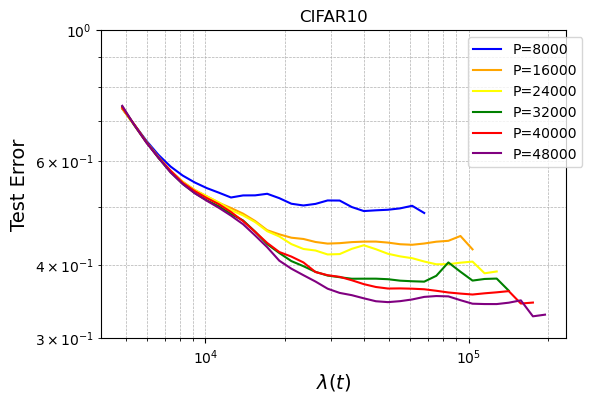

/tmp/ipykernel_8529/2013085822.py:81: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


<Figure size 600x400 with 0 Axes>

In [135]:
model = "CNN"
dataset = "CIFAR10"
final = "_SGD"
WD = 0.0
P_arr = np.arange(8000, 48001, 8000)
seed_arr = np.arange(10,18)
log_x_grid = np.logspace(3.5, 5.75, num=50)

mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=False, ylimit=(0.3,1.0))

/tmp/ipykernel_8529/490518209.py:30: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


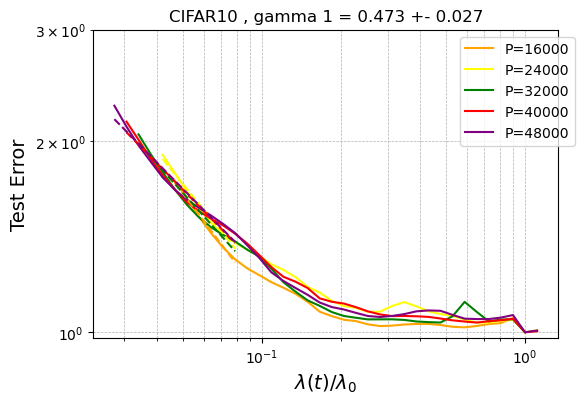

In [136]:
min_P = 1
x_left = None
x_right = 0.8e-1

exponential = False

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = (0.98, 3))

Fitted power law: k2 = 859.9, gamma2 = 0.4276


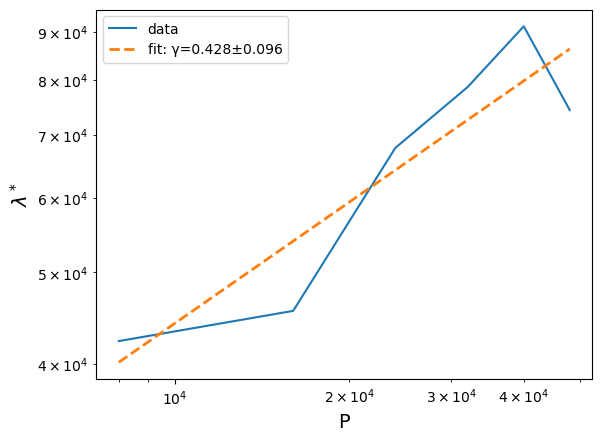

In [137]:
l_power_law = l_0_arr[:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr, l_power_law)
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

gamma_pred =  0.2024652061601069


/tmp/ipykernel_8529/1706596836.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


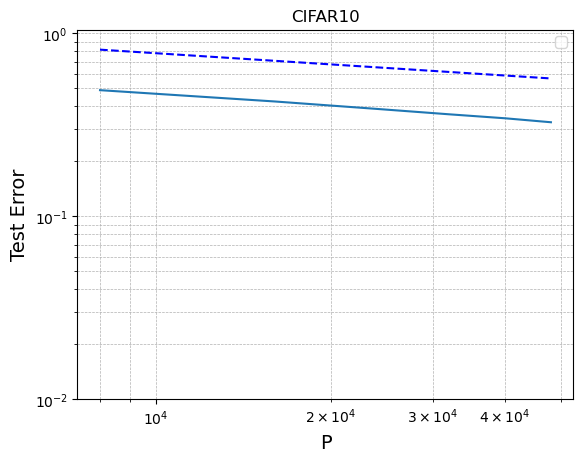

In [138]:
constant = 300
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-2,1.05))

## C100

/tmp/ipykernel_8529/2013085822.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


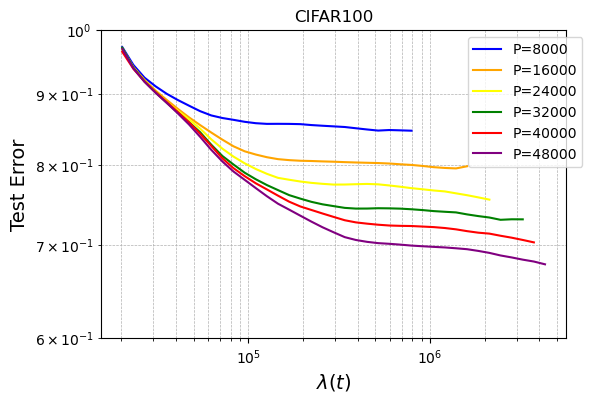

/tmp/ipykernel_8529/2013085822.py:81: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


<Figure size 600x400 with 0 Axes>

In [130]:
model = "CNN"
dataset = "CIFAR100"
final = "_SGD"
WD = 0.0
P_arr = np.arange(8000, 48001, 8000)
seed_arr = np.arange(10,18)
log_x_grid = np.logspace(4, 7, num=50)

mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=False, ylimit=(0.6,1.0))

/tmp/ipykernel_8529/490518209.py:30: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


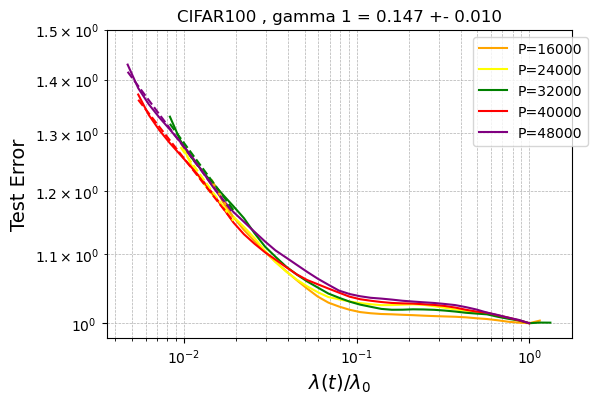

In [131]:
####################

min_P = 1
x_left = None
x_right = 2e-2
exponential = False
to_save["min_P"] = min_P

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = (0.98, 1.5))


[ 8000 16000 24000 32000 40000 48000]
[ 689343.3515625 1317313.53125   2105003.25      2765877.28125
 3497758.1875    4283586.78125  ]
Fitted power law: k2 = 68.39, gamma2 = 1.023


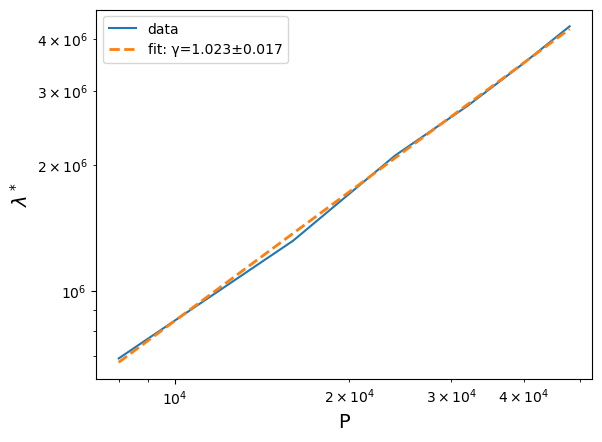

In [132]:
#####################
print(P_arr)
print(l_0_arr)
l_power_law = l_0_arr[:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr, l_power_law)
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")


gamma_pred =  0.15030374172368055


/tmp/ipykernel_8529/1706596836.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


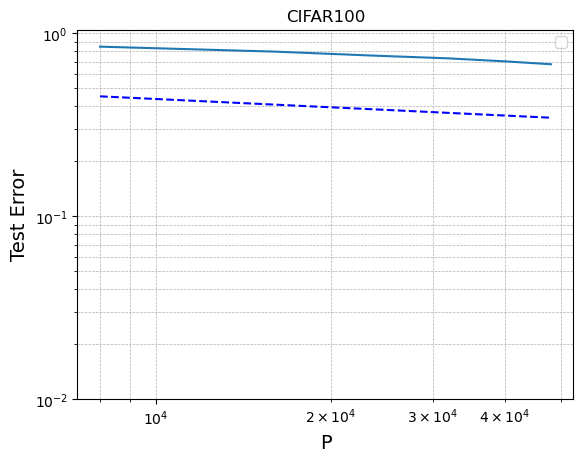

In [133]:
#####################

constant = 5
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-2,1.05))


# Analysis on CIFAR10 dataset: other Norms and effect of WD

## CNN

### Norms

/tmp/ipykernel_105315/2074010599.py:43: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


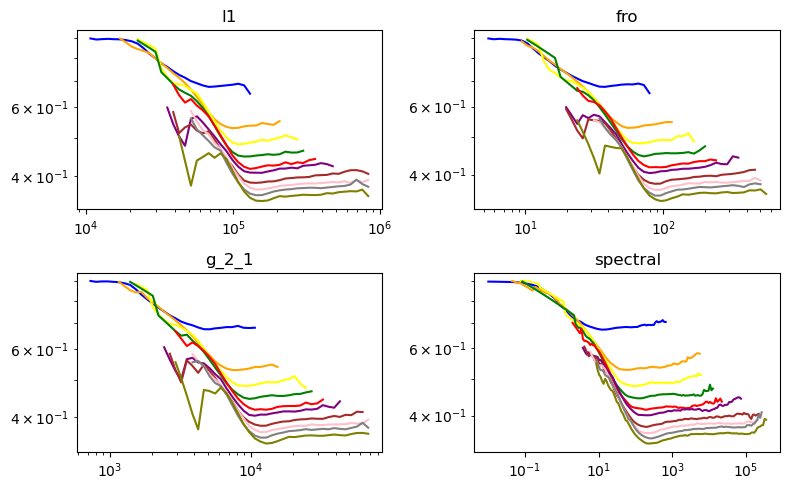

In [64]:
dataset = "CIFAR10"
P_arr = np.arange(1000, 46001, 5000)
seed_arr = np.arange(100,130)
wd=0.0

norms_name = np.array(["l1","fro","g_2_1","spectral"])

#wd_names = np.array(["1_2","1_3","1_4","1_5"])

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
line_styles = ['-', '-.', ':', '--']

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(-2, 6, num=200)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(norms_name), len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

fig, axs = plt.subplots(2,2, figsize=(8,5))

for i_norm, norm in enumerate(norms_name):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.05.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved[norm])
            val_error = np.array(logs_saved["val_error"])*0.01
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_val_error_arr[i_norm, i_P] = mean_val_error
    
        # Plot the mean curve
        axs.flatten()[i_norm].plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])
        axs.flatten()[i_norm].set_title(norm)
        axs.flatten()[i_norm].set_xscale("log")
        axs.flatten()[i_norm].set_yscale("log")

#plt.set_xlabel(r"$\lambda(t)$", fontsize=14)
#plt.set_ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title(dataset)
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
#plt.ylim((0.25,0.8))
fig.tight_layout()
plt.show()

/tmp/ipykernel_105315/104234404.py:29: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


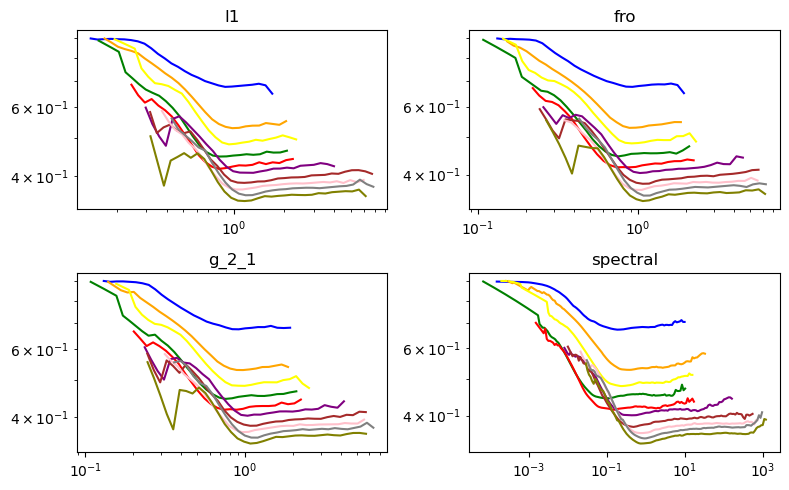

In [66]:
# Store interpolated results here
mean_curves = {}

fig, axs = plt.subplots(2,2, figsize=(8,5))
l_0_arr = np.zeros((len(norms_name),len(P_arr)))
for i_norm, norm in enumerate(norms_name):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.05.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved[norm])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
            idx_zero  = np.argmin((val_error)**2)
            where_zero = model_norm[idx_zero]
            w_z += where_zero/(len(seed_arr))
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        l_0_arr[i_norm, i_P] = w_z
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_curves[i_P] = mean_val_error
    
        # Plot the mean curve
        axs.flatten()[i_norm].plot(log_x_grid/w_z, mean_val_error,
                 color=colorlist[i_P], label=f"P={P}")
        axs.flatten()[i_norm].set_title(norm)
        axs.flatten()[i_norm].set_xscale("log")
        axs.flatten()[i_norm].set_yscale("log")

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["l_0_arr"] = l_0_arr
        
#plt.yscale("log")
#plt.xscale("log")
#plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
#plt.ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title(dataset)
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
fig.tight_layout()
plt.show()

0
1


/tmp/ipykernel_105315/3950505916.py:34: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


2
3


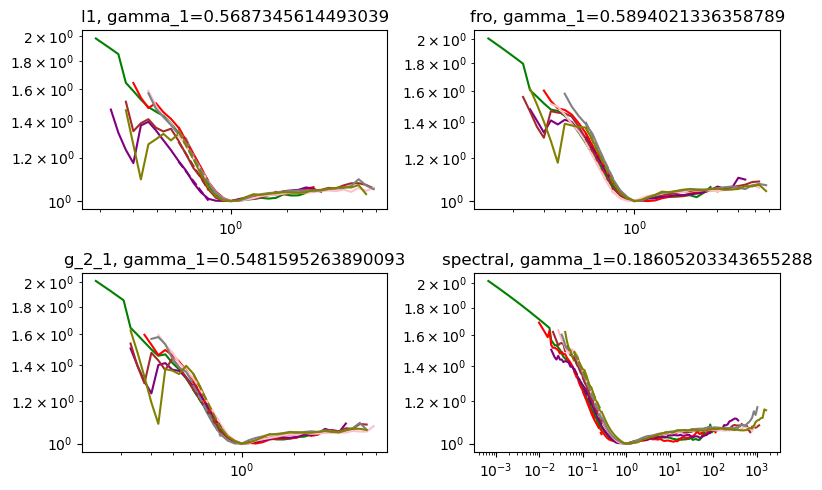

In [67]:
# Store interpolated results here
min_P = 3
P_arr_fit = P_arr[min_P:]

mean_curves = {}

x_left_arr = np.array([5e-1, 5e-1, 5e-1, 6e-2])
x_right_arr = np.array([8e-1,8e-1, 8e-1,3e-1])

gamma_1_arr = np.zeros(len(norms_name))
err_gamma_1_arr = np.zeros(len(norms_name))

fig, axs = plt.subplots(2,2, figsize=(8,5))

for i_norm, norm in enumerate(norms_name):
    print(i_norm)
    for i_P, P in enumerate(P_arr_fit):
        
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.05.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved[norm])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        
        idx = np.nanargmin(mean_val_error)
        # Plot the mean curve
        axs.flatten()[i_norm].plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
                 color=colorlist[i_P+min_P], label=f"P={P}")


    x_left = x_left_arr[i_norm]
    x_right = x_right_arr[i_norm]
    gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr[i_norm], P_arr_fit, min_P, x_left, x_right, colorlist, ax= axs.flatten()[i_norm])
    gamma_1_arr[i_norm] = gamma_1
    err_gamma_1_arr[i_norm] = err_gamma_1

    axs.flatten()[i_norm].set_title(f"{norm}, gamma_1={gamma_1}")
    axs.flatten()[i_norm].set_xscale("log")
    axs.flatten()[i_norm].set_yscale("log")

to_save["x_left_arr"] = x_left_arr
to_save["x_right_arr"] = x_right_arr
to_save["gamma_1_arr"] = gamma_1_arr
to_save["err_gamma_1_arr"] = err_gamma_1_arr


fig.tight_layout()
plt.show()

In [81]:
print(gamma_1_arr[0],gamma_1_arr[1],gamma_1_arr[2],gamma_1_arr[3])
print(err_gamma_1_arr[0],err_gamma_1_arr[1],err_gamma_1_arr[2],err_gamma_1_arr[3])

0.46929763874470215 0.5039758391985285 0.46658208592152584 0.18068620104219033
0.04425161923180171 0.03657570744319162 0.037821993582578275 0.004822780206099512


Fitted power law wd=0.0: k2 = 2.96e+04, gamma2 = 0.1458
Fitted power law wd=0.0: k2 = 11.16, gamma2 = 0.2
Fitted power law wd=0.0: k2 = 1567, gamma2 = 0.1958
Fitted power law wd=0.0: k2 = 5.301, gamma2 = 0.4339


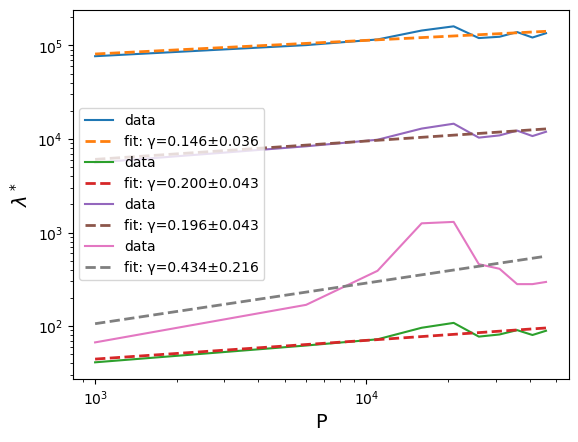

In [68]:
gamma_2_arr = np.zeros(len(norms_name))
err_gamma_2_arr = np.zeros(len(norms_name))

for i_norm, norm in enumerate(norms_name):
    l_power_law = l_0_arr[i_norm, :]
    k2, gamma_2,err_gamma_2  = fit_and_plot_powerlaw(P_arr[:], l_power_law)
    print(f"Fitted power law wd={wd}: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
    gamma_2_arr[i_norm] = gamma_2
    err_gamma_2_arr[i_norm] = err_gamma_2

to_save["gamma_2_arr"] = gamma_2_arr
to_save["err_gamma_2_arr"] = err_gamma_2_arr

In [69]:
for i_norm, norm in enumerate(norms_name):
    gamma_1 = gamma_1_arr[i_norm]
    gamma_2 = gamma_2_arr[i_norm]
    print("Norm=", norm," gamma_pred=", gamma_1*gamma_2)

Norm= l1  gamma_pred= 0.0828947555898544
Norm= fro  gamma_pred= 0.11788852687275894
Norm= g_2_1  gamma_pred= 0.10731322217565552
Norm= spectral  gamma_pred= 0.0807264439176963


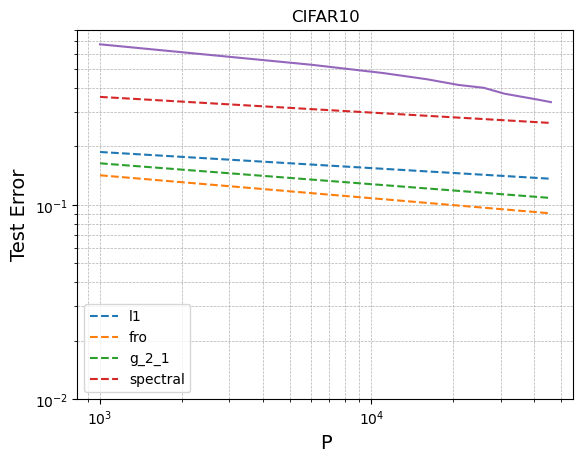

In [71]:
colors = np.array(["blue","red","green"])

for i_norm, norm in enumerate(norms_name):
    eps_lam_star_P_arr = np.zeros(len(P_arr))
    
    lambda_star_arr = np.zeros(len(P_arr))

    for i_P,P in enumerate(P_arr):
         idx = np.nanargmin(mean_val_error_arr[i_norm,i_P])
         #idx = ((log_x_grid-l_power_law[i_P])**2) 
         eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_norm,i_P,idx]
         lambda_star_arr[i_P] = log_x_grid[idx]
    
    plt.plot(P_arr, k1*(k2*P_arr**gamma_2_arr[i_norm])**-gamma_1_arr[i_norm], "--", label=norm)
    #plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.plot(P_arr, eps_lam_star_P_arr)

to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr


plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((1e-2,0.8))
plt.show()

### WD

/tmp/ipykernel_8529/1006672970.py:40: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


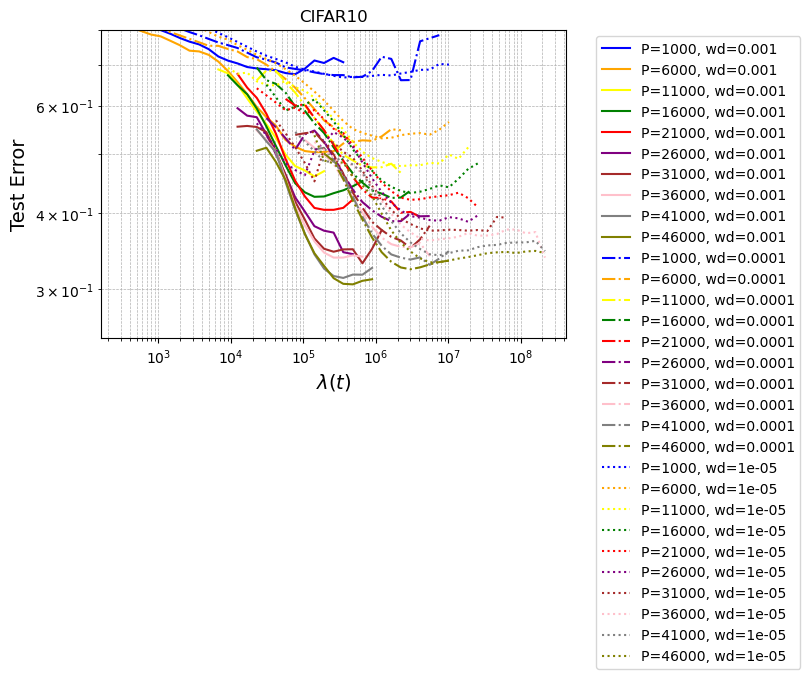

In [140]:
dataset = "CIFAR10"
P_arr = np.arange(1000, 46001, 5000)
seed_arr = np.arange(100,119)
wd_arr = np.array([0.001,0.0001, 0.00001])
#wd_names = np.array(["1_2","1_3","1_4","1_5"])

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
line_styles = ['-', '-.', ':', '--']

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(2.5, 9, num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(wd_arr), len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.05.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved["model_norm"])
            val_error = np.array(logs_saved["val_error"])*0.01
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_val_error_arr[i_wd, i_P] = mean_val_error
    
        # Plot the mean curve
        plt.plot(log_x_grid, mean_val_error, label=f"P={P}, wd={wd}", color=colorlist[i_P],  linestyle=line_styles[i_wd])

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.25,0.8))
plt.show()

/tmp/ipykernel_8529/4035201954.py:30: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


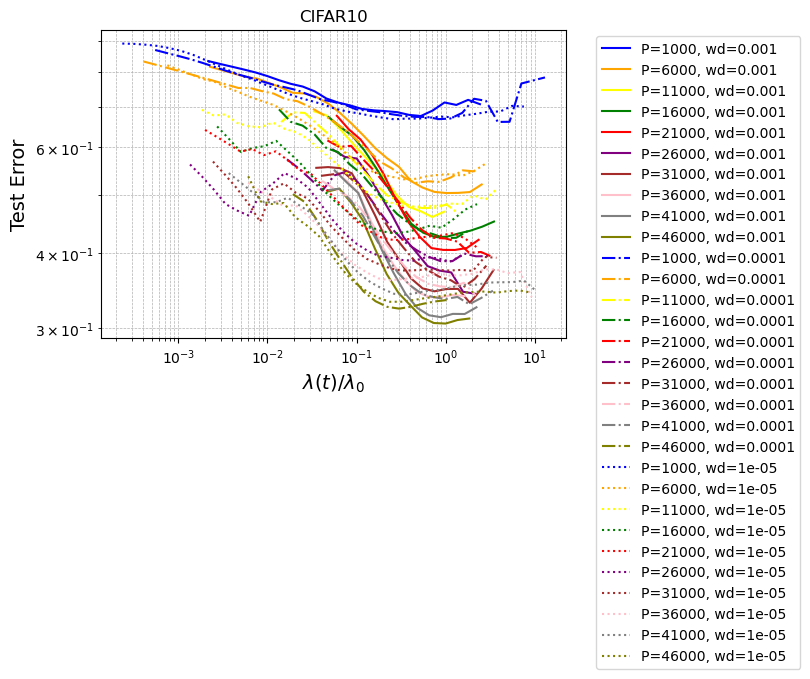

In [143]:
# Store interpolated results here
mean_curves = {}


plt.figure(figsize=(6,4))
l_0_arr = np.zeros((len(wd_arr),len(P_arr)))
for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.05.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved["model_norm"])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
            idx_zero  = np.argmin((val_error)**2)
            where_zero = model_norm[idx_zero]
            w_z += where_zero/(len(seed_arr))
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        l_0_arr[i_wd, i_P] = w_z
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_curves[i_P] = mean_val_error
    
        # Plot the mean curve
        plt.plot(log_x_grid/w_z, mean_val_error,
                 color=colorlist[i_P], label=f"P={P}, wd={wd}", linestyle=line_styles[i_wd])
    
to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["l_0_arr"] = l_0_arr

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_8529/2815193679.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


0.7745400283632351
0.7862723699001805
0.8999142022081178


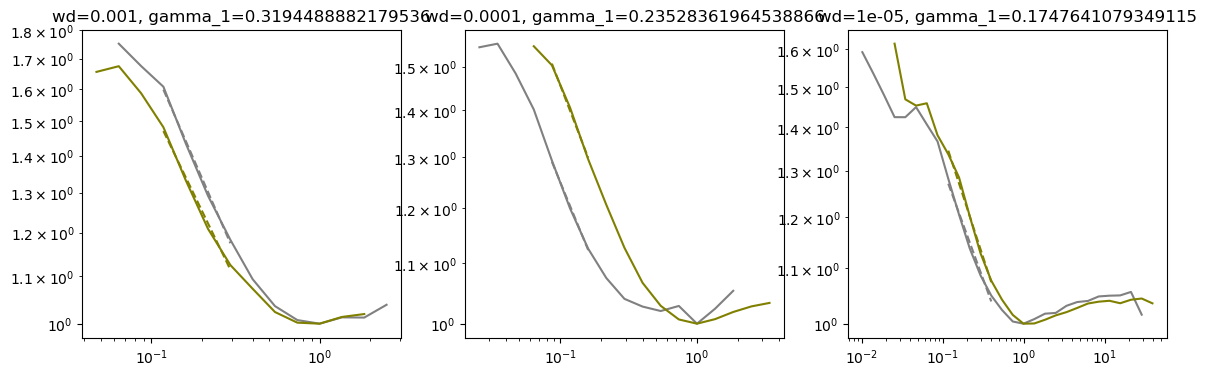

In [144]:
# Store interpolated results here
min_P = 8
P_arr_fit = P_arr[min_P:]

mean_curves = {}

x_left_arr = np.array([0.9e-1, 0.8e-1, 9e-2])
x_right_arr = np.array([3e-1,1.8e-1, 4e-1])

gamma_1_arr = np.zeros(len(wd_arr))
err_gamma_1_arr = np.zeros(len(wd_arr))

fig, axs = plt.subplots(1,3, figsize=(14,4))
    
for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr_fit):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.05.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved["model_norm"])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        
        idx = np.nanargmin(mean_val_error)
        # Plot the mean curve
        axs.flatten()[i_wd].plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
                 color=colorlist[i_P+min_P], label=f"P={P}, wd={wd}")
    
    x_left = x_left_arr[i_wd]
    x_right = x_right_arr[i_wd]
    gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr[i_wd], P_arr_fit, min_P, x_left, x_right, colorlist, ax= axs.flatten()[i_wd])
    gamma_1_arr[i_wd] = gamma_1
    err_gamma_1_arr[i_wd] = err_gamma_1
    axs.flatten()[i_wd].set_title(f"wd={wd}, gamma_1={gamma_1}")
    axs.flatten()[i_wd].set_xscale("log")
    axs.flatten()[i_wd].set_yscale("log")
    print(k1)

to_save["x_left_arr"] = x_left_arr
to_save["x_right_arr"] = x_right_arr
to_save["gamma_1_arr"] = gamma_1_arr
to_save["err_gamma_1_arr"] = err_gamma_1_arr

#plt.yscale("log")
#plt.xscale("log")
#plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
#plt.ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
#plt.ylim((0.97,1.8))
plt.show()

Fitted power law wd=0.001: k2 = 1.246e+04, gamma2 = 0.3095
Fitted power law wd=0.0001: k2 = 1.3e+04, gamma2 = 0.5132
Fitted power law wd=1e-05: k2 = 4304, gamma2 = 0.8002


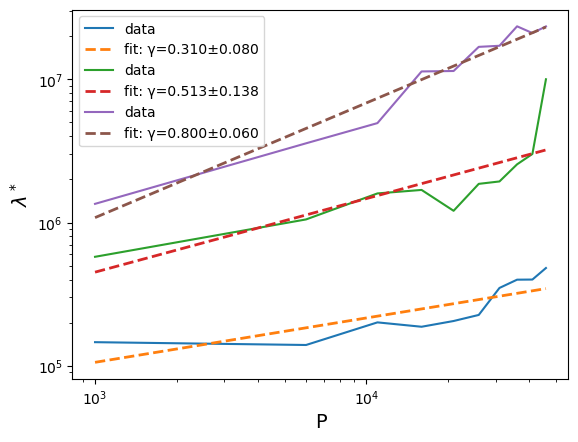

In [96]:
gamma_2_arr = np.zeros(len(wd_arr))
err_gamma_2_arr = np.zeros(len(wd_arr))

for i_wd, wd in enumerate(wd_arr):
    l_power_law = l_0_arr[i_wd, :]
    k2, gamma_2,err_gamma_2  = fit_and_plot_powerlaw(P_arr[:], l_power_law)
    print(f"Fitted power law wd={wd}: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
    gamma_2_arr[i_wd] = gamma_2
    err_gamma_2_arr[i_wd] = err_gamma_2

to_save["gamma_2_arr"] = gamma_2_arr
to_save["err_gamma_2_arr"] = err_gamma_2_arr

In [97]:
for i_wd, wd in enumerate(wd_arr):
    gamma_1 = gamma_1_arr[i_wd]
    gamma_2 = gamma_2_arr[i_wd]
    print("wd=", wd," gamma_pred=", gamma_1*gamma_2)

wd= 0.001  gamma_pred= 0.09888033819680012
wd= 0.0001  gamma_pred= 0.12074427441716393
wd= 1e-05  gamma_pred= 0.13984034734933354


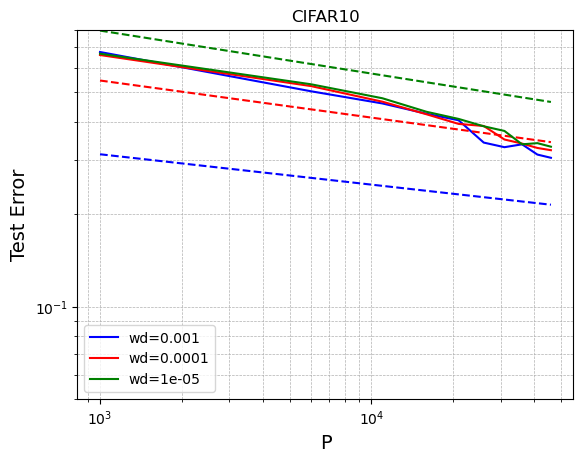

In [98]:
colors = np.array(["blue","red","green"])
eps_lam_star_P_arr = np.zeros((len(wd_arr),len(P_arr)))
lambda_star_arr = np.zeros((len(wd_arr),len(P_arr)))

for i_wd, wd in enumerate(wd_arr):   
    for i_P,P in enumerate(P_arr):
         idx = np.nanargmin(mean_val_error_arr[i_wd,i_P])
         #idx = ((log_x_grid-l_power_law[i_P])**2) 
         eps_lam_star_P_arr[i_wd, i_P] = mean_val_error_arr[i_wd,i_P,idx]
         lambda_star_arr[i_wd, i_P] = log_x_grid[idx]
    
    plt.plot(P_arr, eps_lam_star_P_arr[i_wd], color=colors[i_wd], label=f"wd={wd}")
    
    plt.plot(P_arr, 10*k1*(k2*P_arr**gamma_2_arr[i_wd])**-gamma_1_arr[i_wd], "--", color=colors[i_wd])
    #plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((5e-2,0.8))
plt.show()

## ResNet

### Norms

/tmp/ipykernel_105315/1581372706.py:43: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


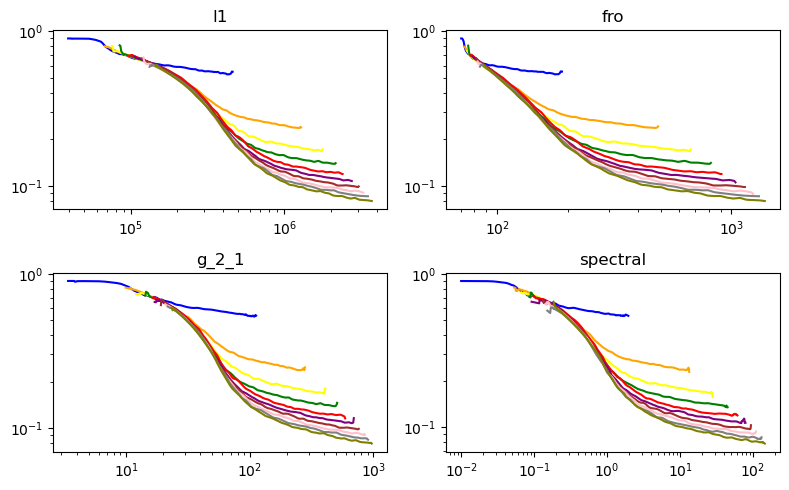

In [49]:
dataset = "CIFAR10"
P_arr = np.arange(1000, 46001, 5000)
seed_arr = np.arange(100,120)
wd=0.0

norms_name = np.array(["l1","fro","g_2_1","spectral"])

#wd_names = np.array(["1_2","1_3","1_4","1_5"])

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
line_styles = ['-', '-.', ':', '--']

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(-2, 8, num=2000)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(norms_name), len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

fig, axs = plt.subplots(2,2, figsize=(8,5))

for i_norm, norm in enumerate(norms_name):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.005.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved[norm])
            val_error = np.array(logs_saved["val_error"])*0.01
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_val_error_arr[i_norm, i_P] = mean_val_error
    
        # Plot the mean curve
        axs.flatten()[i_norm].plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])
        axs.flatten()[i_norm].set_title(norm)
        axs.flatten()[i_norm].set_xscale("log")
        axs.flatten()[i_norm].set_yscale("log")


#plt.set_xlabel(r"$\lambda(t)$", fontsize=14)
#plt.set_ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title(dataset)
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
#plt.ylim((0.25,0.8))
fig.tight_layout()
plt.show()

/tmp/ipykernel_105315/4047995839.py:29: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


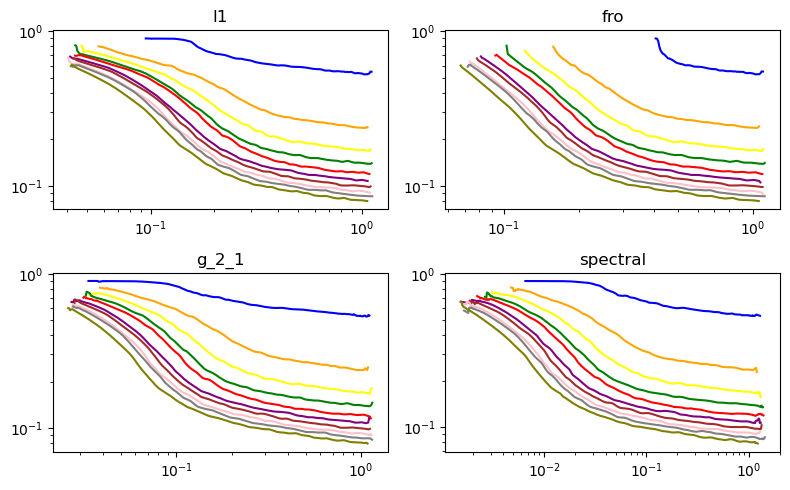

In [50]:
# Store interpolated results here
mean_curves = {}

fig, axs = plt.subplots(2,2, figsize=(8,5))
l_0_arr = np.zeros((len(norms_name),len(P_arr)))
for i_norm, norm in enumerate(norms_name):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.005.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved[norm])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
            idx_zero  = np.argmin((val_error)**2)
            where_zero = model_norm[idx_zero]
            w_z += where_zero/(len(seed_arr))
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        l_0_arr[i_norm, i_P] = w_z
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_curves[i_P] = mean_val_error
    
        # Plot the mean curve
        axs.flatten()[i_norm].plot(log_x_grid/w_z, mean_val_error,
                 color=colorlist[i_P], label=f"P={P}")
        axs.flatten()[i_norm].set_title(norm)
        axs.flatten()[i_norm].set_xscale("log")
        axs.flatten()[i_norm].set_yscale("log")

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["l_0_arr"] = l_0_arr
        
#plt.yscale("log")
#plt.xscale("log")
#plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
#plt.ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title(dataset)
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
fig.tight_layout()
plt.show()

0


/tmp/ipykernel_105315/1388843987.py:34: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


1
2
3


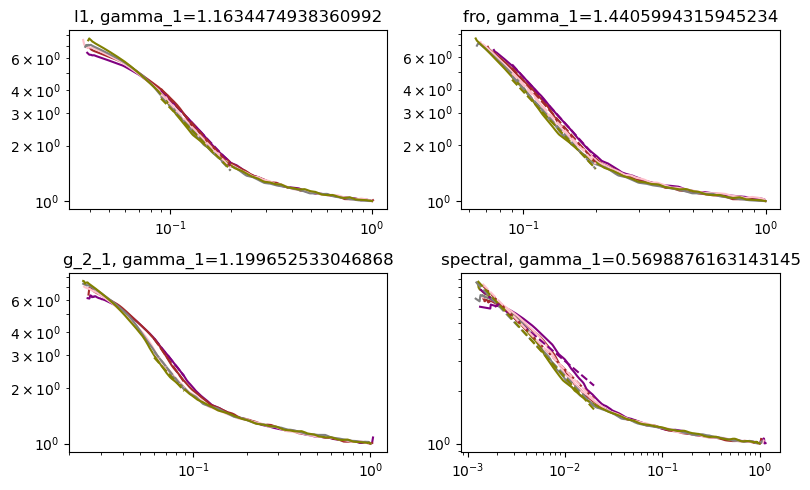

In [51]:
# Store interpolated results here
min_P = 5
P_arr_fit = P_arr[min_P:]

mean_curves = {}

x_left_arr = np.array([9e-2, 9e-2, 6e-2, None])
x_right_arr = np.array([2e-1,2e-1, 9e-2,2e-2])

gamma_1_arr = np.zeros(len(norms_name))
err_gamma_1_arr = np.zeros(len(norms_name))

fig, axs = plt.subplots(2,2, figsize=(8,5))

for i_norm, norm in enumerate(norms_name):
    print(i_norm)
    for i_P, P in enumerate(P_arr_fit):
        
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.005.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved[norm])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        
        idx = np.nanargmin(mean_val_error)
        # Plot the mean curve
        axs.flatten()[i_norm].plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
                 color=colorlist[i_P+min_P], label=f"P={P}")


    x_left = x_left_arr[i_norm]
    x_right = x_right_arr[i_norm]
    gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr[i_norm], P_arr_fit, min_P, x_left, x_right, colorlist, ax= axs.flatten()[i_norm])
    gamma_1_arr[i_norm] = gamma_1
    err_gamma_1_arr[i_norm] = err_gamma_1

    axs.flatten()[i_norm].set_title(f"{norm}, gamma_1={gamma_1}")
    axs.flatten()[i_norm].set_xscale("log")
    axs.flatten()[i_norm].set_yscale("log")

to_save["x_left_arr"] = x_left_arr
to_save["x_right_arr"] = x_right_arr
to_save["gamma_1_arr"] = gamma_1_arr
to_save["err_gamma_1_arr"] = err_gamma_1_arr


#plt.yscale("log")
#plt.xscale("log")
#plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
#plt.ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
#plt.ylim((0.97,1.8))
fig.tight_layout()
plt.show()

Fitted power law wd=0.0: k2 = 9961, gamma2 = 0.5447
Fitted power law wd=0.0: k2 = 4.793, gamma2 = 0.5208
Fitted power law wd=0.0: k2 = 1.924, gamma2 = 0.5669
Fitted power law wd=0.0: k2 = 0.0006341, gamma2 = 1.124


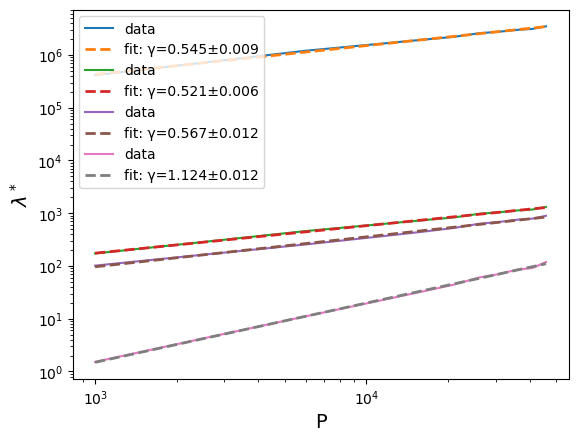

In [52]:
gamma_2_arr = np.zeros(len(norms_name))
err_gamma_2_arr = np.zeros(len(norms_name))

for i_norm, norm in enumerate(norms_name):
    l_power_law = l_0_arr[i_norm, :]
    k2, gamma_2,err_gamma_2  = fit_and_plot_powerlaw(P_arr[:], l_power_law)
    print(f"Fitted power law wd={wd}: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
    gamma_2_arr[i_norm] = gamma_2
    err_gamma_2_arr[i_norm] = err_gamma_2

to_save["gamma_2_arr"] = gamma_2_arr
to_save["err_gamma_2_arr"] = err_gamma_2_arr

In [53]:
for i_norm, norm in enumerate(norms_name):
    gamma_1 = gamma_1_arr[i_norm]
    gamma_2 = gamma_2_arr[i_norm]
    print("Norm=", norm," gamma_pred=", gamma_1*gamma_2)

Norm= l1  gamma_pred= 0.6336834076258961
Norm= fro  gamma_pred= 0.7502527685220504
Norm= g_2_1  gamma_pred= 0.6801217692894101
Norm= spectral  gamma_pred= 0.6405166616329793


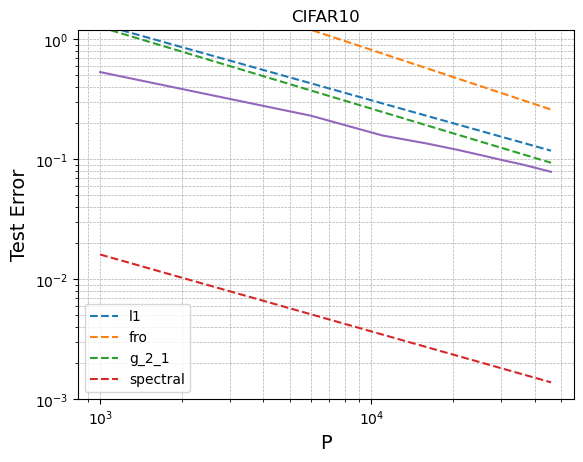

In [54]:
colors = np.array(["blue","red","green"])

for i_norm, norm in enumerate(norms_name):
    eps_lam_star_P_arr = np.zeros(len(P_arr))
    
    lambda_star_arr = np.zeros(len(P_arr))

    for i_P,P in enumerate(P_arr):
         idx = np.nanargmin(mean_val_error_arr[i_norm,i_P])
         #idx = ((log_x_grid-l_power_law[i_P])**2) 
         eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_norm,i_P,idx]
         lambda_star_arr[i_P] = log_x_grid[idx]
    
    plt.plot(P_arr, 0.1*k1*(k2*P_arr**gamma_2_arr[i_norm])**-gamma_1_arr[i_norm], "--", label=norm)
    #plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.plot(P_arr, eps_lam_star_P_arr)

to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr


plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((1e-3,1.2))
plt.show()

### WD

/tmp/ipykernel_17033/3291446704.py:41: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


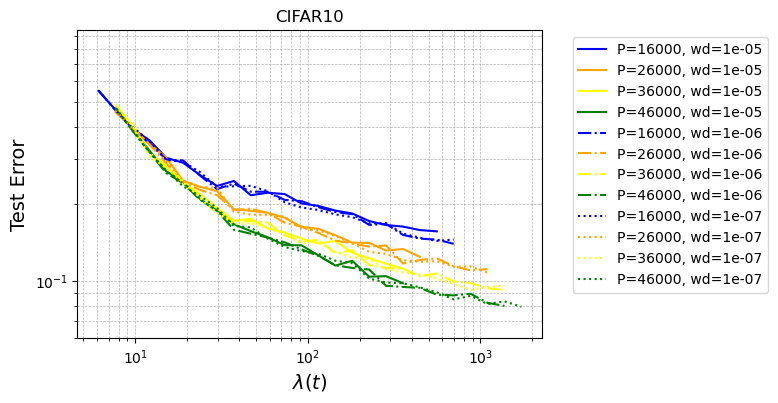

In [8]:
dataset = "CIFAR10"
P_arr = np.arange(16000, 46001, 10000)
seed_arr = np.arange(1000,1001)
wd_arr = np.array([1e-5, 1e-6,1e-7])
#wd_names = np.array(["1_2","1_3","1_4","1_5"])

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
line_styles = ['-', '-.', ':', '--']

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(0.2, 5, num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(wd_arr), len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}_INIT1.0.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved["model_norm"])
            val_error = np.array(logs_saved["val_error"])*0.01
            #model_norm, val_error = trim_by_monotone_model_norm(model_norm, val_error, allow_equal=True)
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_val_error_arr[i_wd, i_P] = mean_val_error
    
        # Plot the mean curve
        plt.plot(log_x_grid, mean_val_error, label=f"P={P}, wd={wd}", color=colorlist[i_P],  linestyle=line_styles[i_wd])

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.06,0.95))
plt.show()

/tmp/ipykernel_17033/3235891434.py:30: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


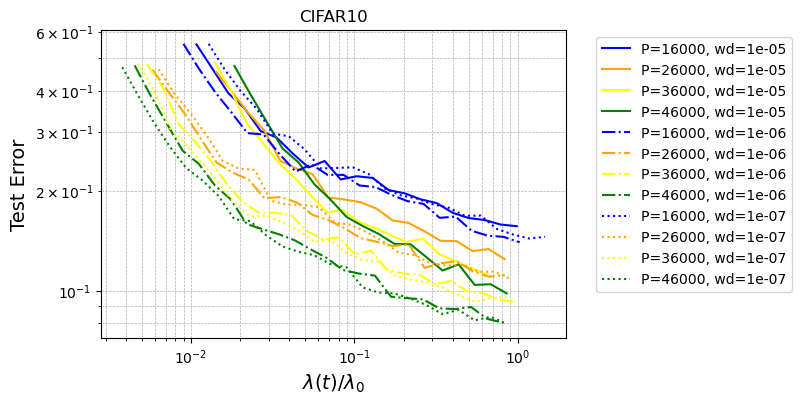

In [13]:
# Store interpolated results here
mean_curves = {}

plt.figure(figsize=(6,4))
l_0_arr = np.zeros((len(wd_arr),len(P_arr)))
for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}_INIT1.0.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved["model_norm"])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
            #model_norm, val_error = trim_by_monotone_model_norm(model_norm, val_error, allow_equal=True)
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)

            idx_zero  = np.argmin((val_error)**2)
            where_zero = model_norm[idx_zero]
            w_z += where_zero/(len(seed_arr))
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        l_0_arr[i_wd, i_P] = w_z
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_curves[i_P] = mean_val_error
    
        # Plot the mean curve
        plt.plot(log_x_grid/w_z, mean_val_error,
                 color=colorlist[i_P], label=f"P={P}, wd={wd}", linestyle=line_styles[i_wd])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_17033/4197365722.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


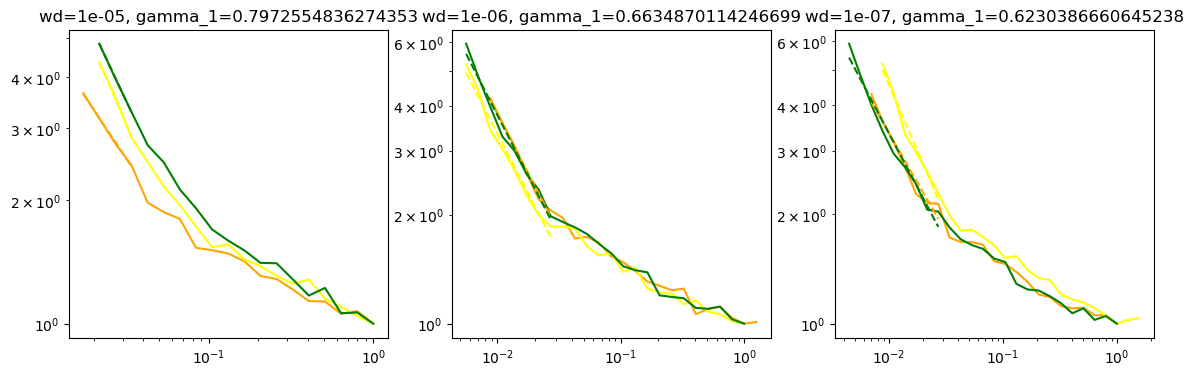

In [27]:
# Store interpolated results here
min_P = 1
P_arr_fit = P_arr[min_P:]

mean_curves = {}

x_left_arr = np.array([None, None, None])
x_right_arr = np.array([4e-2,3e-2, 3e-2])

gamma_1_arr = np.zeros(len(wd_arr))
err_gamma_1_arr = np.zeros(len(wd_arr))

fig, axs = plt.subplots(1,3, figsize=(14,4))
    
for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr_fit):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}_INIT1.0.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved["model_norm"])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        
        idx = np.nanargmin(mean_val_error)
        # Plot the mean curve
        axs.flatten()[i_wd].plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
                 color=colorlist[i_P+min_P], label=f"P={P}, wd={wd}")
    
    x_left = x_left_arr[i_wd]
    x_right = x_right_arr[i_wd]
    gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr[i_wd], P_arr_fit, min_P, x_left, x_right, colorlist, ax= axs.flatten()[i_wd])
    gamma_1_arr[i_wd] = gamma_1
    err_gamma_1_arr[i_wd] = err_gamma_1
    axs.flatten()[i_wd].set_title(f"wd={wd}, gamma_1={gamma_1}")
    axs.flatten()[i_wd].set_xscale("log")
    axs.flatten()[i_wd].set_yscale("log")

#plt.yscale("log")
#plt.xscale("log")
#plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
#plt.ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
#plt.ylim((0.97,1.8))
plt.show()

Fitted power law wd=1e-05: k2 = 5673, gamma2 = -0.2338
Fitted power law wd=1e-06: k2 = 0.2223, gamma2 = 0.8383
Fitted power law wd=1e-07: k2 = 0.0009831, gamma2 = 1.363


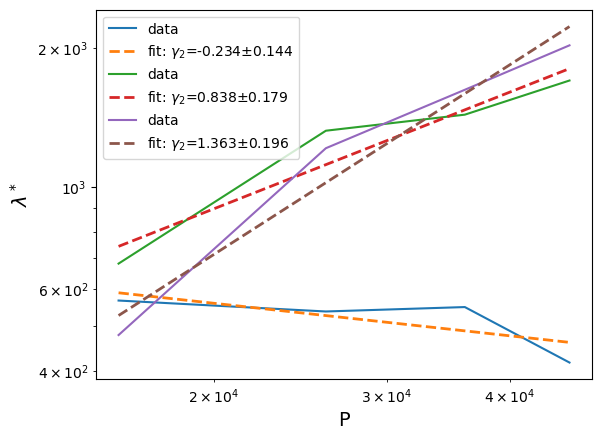

In [28]:
gamma_2_arr = np.zeros(len(wd_arr))
err_gamma_2_arr = np.zeros(len(wd_arr))

for i_wd, wd in enumerate(wd_arr):
    l_power_law = l_0_arr[i_wd, :]
    k2, gamma_2,err_gamma_2  = fit_and_plot_powerlaw(P_arr[:], l_power_law)
    print(f"Fitted power law wd={wd}: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
    gamma_2_arr[i_wd] = gamma_2
    err_gamma_2_arr[i_wd] = err_gamma_2

In [29]:
for i_wd, wd in enumerate(wd_arr):
    gamma_1 = gamma_1_arr[i_wd]
    gamma_2 = gamma_2_arr[i_wd]
    print("wd=", wd," gamma_pred=", gamma_1*(gamma_2))

wd= 1e-05  gamma_pred= -0.18640640178173662
wd= 1e-06  gamma_pred= 0.5561956819461072
wd= 1e-07  gamma_pred= 0.8490357822834204


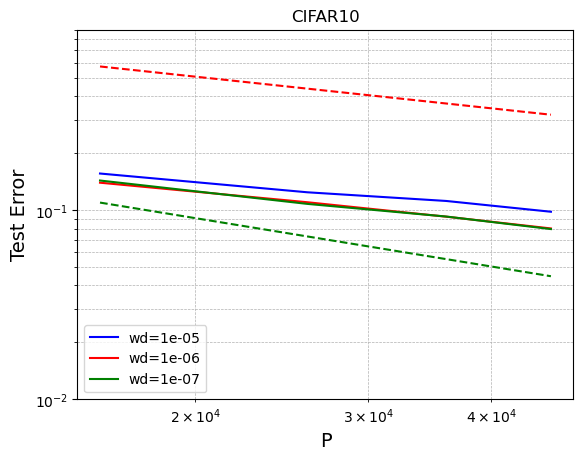

In [30]:
colors = np.array(["blue","red","green"])
for i_wd, wd in enumerate(wd_arr):
    eps_lam_star_P_arr = np.zeros(len(P_arr))
    
    lambda_star_arr = np.zeros(len(P_arr))
    
    for i_P,P in enumerate(P_arr):
         idx = np.nanargmin(mean_val_error_arr[i_wd,i_P])
         #idx = ((log_x_grid-l_power_law[i_P])**2) 
         eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_wd,i_P,idx]
         lambda_star_arr[i_P] = log_x_grid[idx]
    
    plt.plot(P_arr, eps_lam_star_P_arr, color=colors[i_wd], label=f"wd={wd}")
    
    plt.plot(P_arr, 10*gamma_2_arr[i_wd]**3*k1*(k2*P_arr**(gamma_2_arr[i_wd]))**-gamma_1_arr[i_wd], "--", color=colors[i_wd])
    
    #plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((1e-2,0.9))
plt.show()

## ViT

### Norms

/tmp/ipykernel_105315/995173158.py:43: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


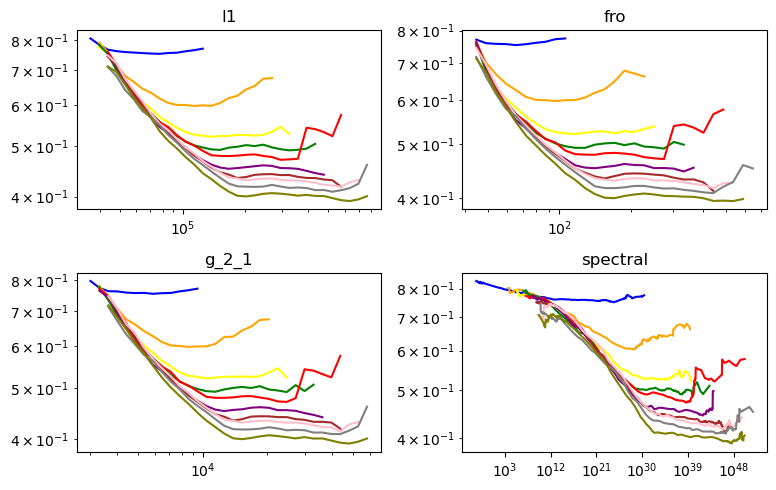

In [78]:
dataset = "CIFAR10"
P_arr = np.arange(1000, 46001, 5000)
seed_arr = np.arange(100,120)
wd=0.0

norms_name = np.array(["l1","fro","g_2_1","spectral"])

#wd_names = np.array(["1_2","1_3","1_4","1_5"])

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
line_styles = ['-', '-.', ':', '--']

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(-3, 80, num=2000)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(norms_name), len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

fig, axs = plt.subplots(2,2, figsize=(8,5))

for i_norm, norm in enumerate(norms_name):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.005.npy", allow_pickle=True).item()
            model_norm = np.exp(np.array(logs_saved[norm]))
            val_error = np.array(logs_saved["val_error"])*0.01
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_val_error_arr[i_norm, i_P] = mean_val_error
    
        # Plot the mean curve
        axs.flatten()[i_norm].plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])
        axs.flatten()[i_norm].set_title(norm)
        axs.flatten()[i_norm].set_xscale("log")
        axs.flatten()[i_norm].set_yscale("log")

fig.tight_layout()
plt.show()

/tmp/ipykernel_105315/1985139213.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


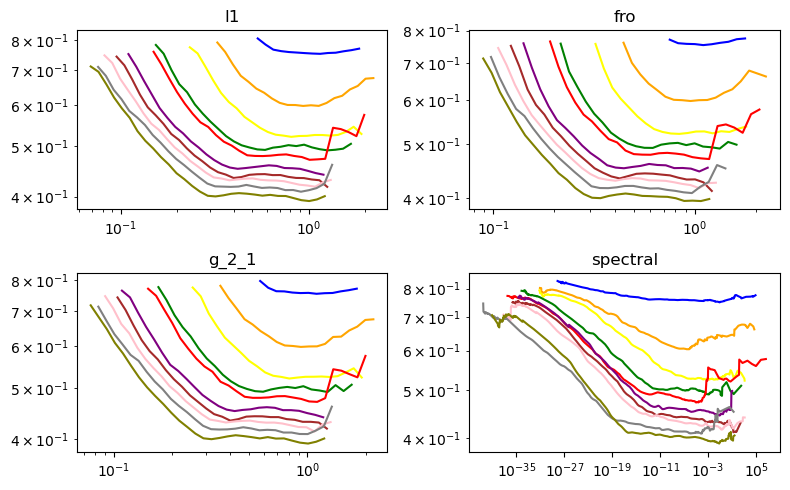

In [79]:
# Store interpolated results here
mean_curves = {}

fig, axs = plt.subplots(2,2, figsize=(8,5))
l_0_arr = np.zeros((len(norms_name),len(P_arr)))
for i_norm, norm in enumerate(norms_name):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        w_z = 0
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.005.npy", allow_pickle=True).item()
            model_norm = np.exp(np.array(logs_saved[norm]))
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
            idx_zero  = np.argmin((val_error)**2)
            where_zero = model_norm[idx_zero]
            w_z += where_zero/(len(seed_arr))
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        l_0_arr[i_norm, i_P] = w_z
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_curves[i_P] = mean_val_error
    
        # Plot the mean curve
        axs.flatten()[i_norm].plot(log_x_grid/w_z, mean_val_error,
                 color=colorlist[i_P], label=f"P={P}")
        axs.flatten()[i_norm].set_title(norm)
        axs.flatten()[i_norm].set_xscale("log")
        axs.flatten()[i_norm].set_yscale("log")

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["l_0_arr"] = l_0_arr
        

fig.tight_layout()
plt.show()

0
1
2
3


/tmp/ipykernel_105315/251534075.py:33: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


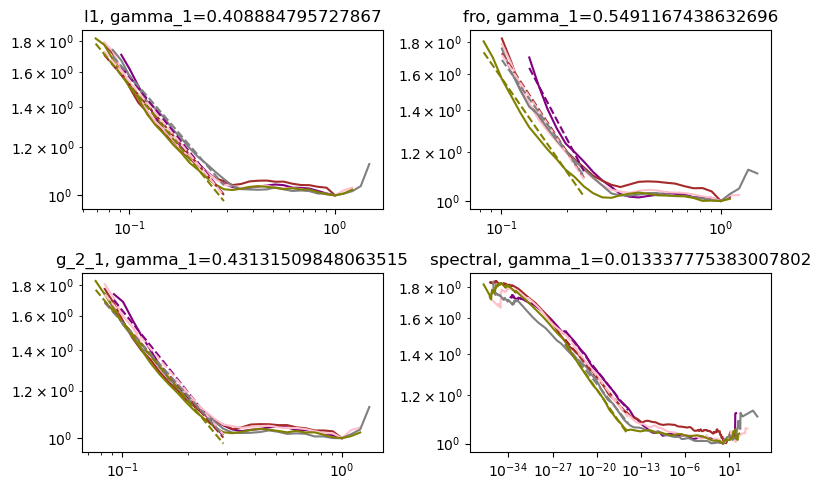

In [80]:
# Store interpolated results here
min_P = 5
P_arr_fit = P_arr[min_P:]

mean_curves = {}

x_left_arr = np.array([None, None, None, 1e-25])
x_right_arr = np.array([3e-1,2.5e-1, 3e-1,1e-15])

gamma_1_arr = np.zeros(len(norms_name))
err_gamma_1_arr = np.zeros(len(norms_name))

fig, axs = plt.subplots(2,2, figsize=(8,5))

for i_norm, norm in enumerate(norms_name):
    print(i_norm)
    for i_P, P in enumerate(P_arr_fit):
        
        interpolated_val_errors = []
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.005.npy", allow_pickle=True).item()
            model_norm = np.exp(np.array(logs_saved[norm]))
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        
        idx = np.nanargmin(mean_val_error)
        # Plot the mean curve
        axs.flatten()[i_norm].plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
                 color=colorlist[i_P+min_P], label=f"P={P}")


    x_left = x_left_arr[i_norm]
    x_right = x_right_arr[i_norm]
    gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr[i_norm], P_arr_fit, min_P, x_left, x_right, colorlist, ax= axs.flatten()[i_norm])
    gamma_1_arr[i_norm] = gamma_1
    err_gamma_1_arr[i_norm] = err_gamma_1

    axs.flatten()[i_norm].set_title(f"{norm}, gamma_1={gamma_1}")
    axs.flatten()[i_norm].set_xscale("log")
    axs.flatten()[i_norm].set_yscale("log")

to_save["x_left_arr"] = x_left_arr
to_save["x_right_arr"] = x_right_arr
to_save["gamma_1_arr"] = gamma_1_arr
to_save["err_gamma_1_arr"] = err_gamma_1_arr


fig.tight_layout()
plt.show()

Fitted power law wd=0.0: k2 = 724.5, gamma2 = 0.617
Fitted power law wd=0.0: k2 = 0.7787, gamma2 = 0.5881
Fitted power law wd=0.0: k2 = 60.23, gamma2 = 0.6075
Fitted power law wd=0.0: k2 = 2.945e-20, gamma2 = 14.5


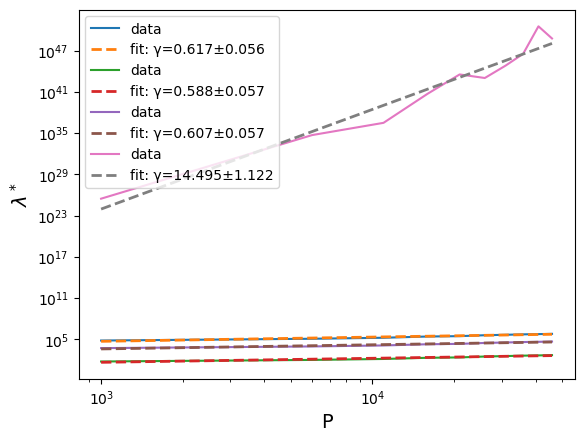

In [81]:
gamma_2_arr = np.zeros(len(norms_name))
err_gamma_2_arr = np.zeros(len(norms_name))

for i_norm, norm in enumerate(norms_name):
    l_power_law = l_0_arr[i_norm, :]
    k2, gamma_2,err_gamma_2  = fit_and_plot_powerlaw(P_arr[:], l_power_law)
    print(f"Fitted power law wd={wd}: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
    gamma_2_arr[i_norm] = gamma_2
    err_gamma_2_arr[i_norm] = err_gamma_2

to_save["gamma_2_arr"] = gamma_2_arr
to_save["err_gamma_2_arr"] = err_gamma_2_arr

In [82]:
for i_norm, norm in enumerate(norms_name):
    gamma_1 = gamma_1_arr[i_norm]
    gamma_2 = gamma_2_arr[i_norm]
    print("Norm=", norm," gamma_pred=", gamma_1*gamma_2)

Norm= l1  gamma_pred= 0.2522712926682627
Norm= fro  gamma_pred= 0.32293004986716906
Norm= g_2_1  gamma_pred= 0.26202003348070474
Norm= spectral  gamma_pred= 0.19333216708040116


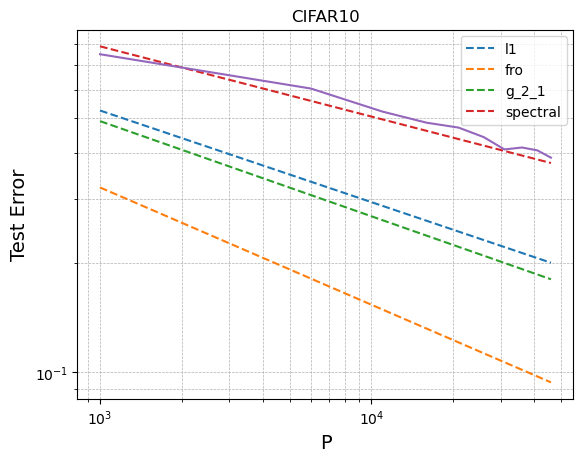

In [83]:
## colors = np.array(["blue","red","green"])

for i_norm, norm in enumerate(norms_name):
    eps_lam_star_P_arr = np.zeros(len(P_arr))
    
    lambda_star_arr = np.zeros(len(P_arr))

    for i_P,P in enumerate(P_arr):
         idx = np.nanargmin(mean_val_error_arr[i_norm,i_P])
         #idx = ((log_x_grid-l_power_law[i_P])**2) 
         eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_norm,i_P,idx]
         lambda_star_arr[i_P] = log_x_grid[idx]
    
    plt.plot(P_arr, 3*(P_arr**gamma_2_arr[i_norm])**-gamma_1_arr[i_norm], "--", label=norm)
    #plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.plot(P_arr, eps_lam_star_P_arr)

to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr


plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((None,None))
plt.show()

### WD

/tmp/ipykernel_105315/3358815188.py:40: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


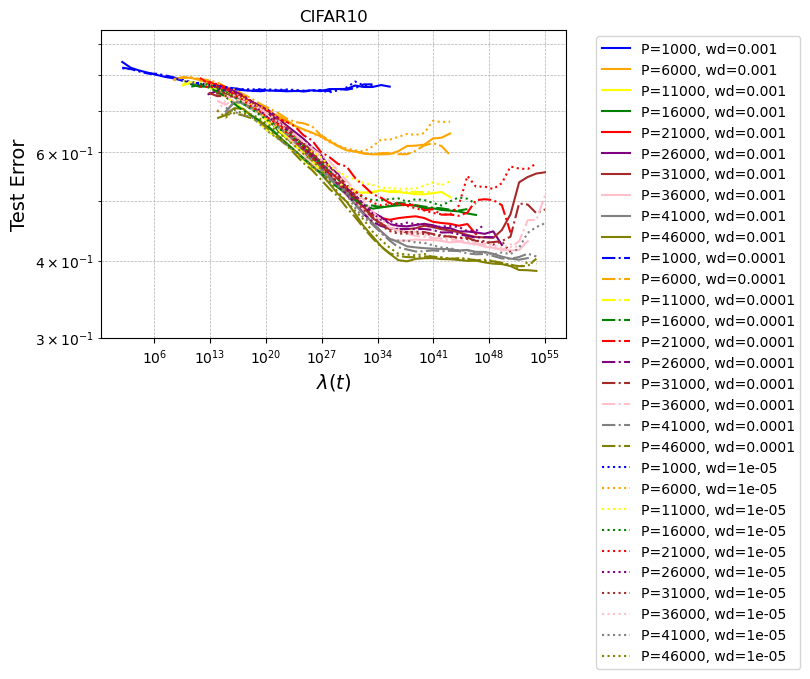

In [7]:
dataset = "CIFAR10"
P_arr = np.arange(1000, 46001, 5000)
seed_arr = np.arange(100,118)
wd_arr = np.array([0.001,0.0001, 0.00001])
#wd_names = np.array(["1_2","1_3","1_4","1_5"])

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
line_styles = ['-', '-.', ':', '--']

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(2, 55, num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(wd_arr), len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.005.npy", allow_pickle=True).item()
            model_norm = np.exp(np.array(logs_saved["model_norm"]))
            val_error = np.array(logs_saved["val_error"])*0.01
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_val_error_arr[i_wd, i_P] = mean_val_error
    
        # Plot the mean curve
        plt.plot(log_x_grid, mean_val_error, label=f"P={P}, wd={wd}", color=colorlist[i_P],  linestyle=line_styles[i_wd])

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.3,0.95))
plt.show()

/tmp/ipykernel_105315/2657923567.py:29: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


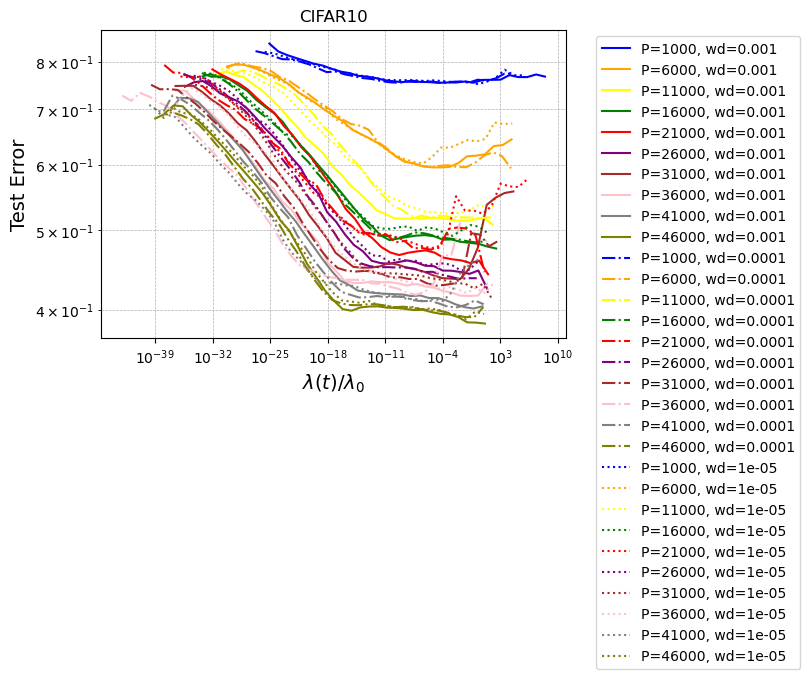

In [11]:
# Store interpolated results here
mean_curves = {}

plt.figure(figsize=(6,4))
l_0_arr = np.zeros((len(wd_arr),len(P_arr)))
for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.005.npy", allow_pickle=True).item()
            model_norm = np.exp(np.array(logs_saved["model_norm"]))
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
            idx_zero  = np.argmin((val_error)**2)
            where_zero = model_norm[idx_zero]
            w_z += where_zero/(len(seed_arr))
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        l_0_arr[i_wd, i_P] = w_z
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_curves[i_P] = mean_val_error
    
        # Plot the mean curve
        plt.plot(log_x_grid/w_z, mean_val_error,
                 color=colorlist[i_P], label=f"P={P}, wd={wd}", linestyle=line_styles[i_wd])
    
to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["l_0_arr"] = l_0_arr

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_105315/1980156336.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


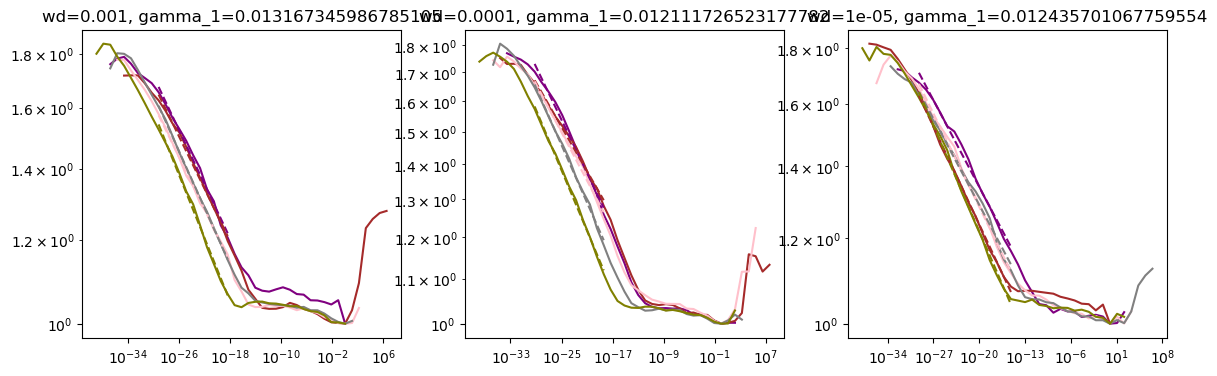

In [12]:
# Store interpolated results here
min_P = 5
P_arr_fit = P_arr[min_P:]

mean_curves = {}

x_left_arr = np.array([1e-30, 1e-30, 1e-30])
x_right_arr = np.array([1e-18,1e-18, 1e-15])

gamma_1_arr = np.zeros(len(wd_arr))
err_gamma_1_arr = np.zeros(len(wd_arr))

fig, axs = plt.subplots(1,3, figsize=(14,4))
    
for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr_fit):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.005.npy", allow_pickle=True).item()
            model_norm = np.exp(np.array(logs_saved["model_norm"]))
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        
        idx = np.nanargmin(mean_val_error)
        # Plot the mean curve
        axs.flatten()[i_wd].plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
                 color=colorlist[i_P+min_P], label=f"P={P}, wd={wd}")
    
    x_left = x_left_arr[i_wd]
    x_right = x_right_arr[i_wd]
    gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr[i_wd], P_arr_fit, min_P, x_left, x_right, colorlist, ax= axs.flatten()[i_wd])
    gamma_1_arr[i_wd] = gamma_1
    err_gamma_1_arr[i_wd] = err_gamma_1
    axs.flatten()[i_wd].set_title(f"wd={wd}, gamma_1={gamma_1}")
    axs.flatten()[i_wd].set_xscale("log")
    axs.flatten()[i_wd].set_yscale("log")

to_save["x_left_arr"] = x_left_arr
to_save["x_right_arr"] = x_right_arr
to_save["gamma_1_arr"] = gamma_1_arr
to_save["err_gamma_1_arr"] = err_gamma_1_arr

plt.show()

Fitted power law wd=0.001: k2 = 3.708e-21, gamma2 = 15.56
Fitted power law wd=0.0001: k2 = 5.218e-23, gamma2 = 16.32
Fitted power law wd=1e-05: k2 = 1.094e-20, gamma2 = 15.52


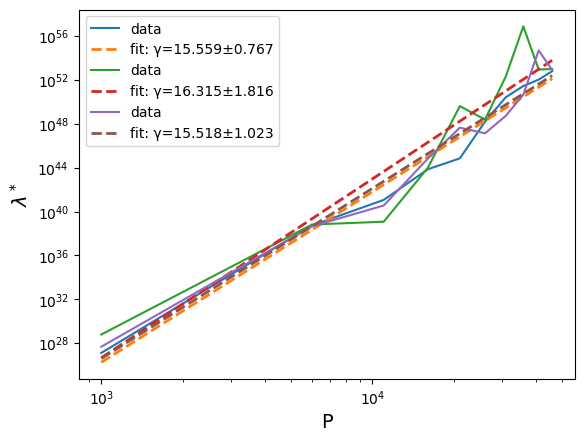

In [13]:
gamma_2_arr = np.zeros(len(wd_arr))
err_gamma_2_arr = np.zeros(len(wd_arr))

for i_wd, wd in enumerate(wd_arr):
    l_power_law = l_0_arr[i_wd, :]
    k2, gamma_2,err_gamma_2  = fit_and_plot_powerlaw(P_arr[:], l_power_law)
    print(f"Fitted power law wd={wd}: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
    gamma_2_arr[i_wd] = gamma_2
    err_gamma_2_arr[i_wd] = err_gamma_2

to_save["gamma_2_arr"] = gamma_2_arr
to_save["err_gamma_2_arr"] = err_gamma_2_arr

In [14]:
for i_wd, wd in enumerate(wd_arr):
    gamma_1 = gamma_1_arr[i_wd]
    gamma_2 = gamma_2_arr[i_wd]
    print("wd=", wd," gamma_pred=", gamma_1*gamma_2)

wd= 0.001  gamma_pred= 0.2048708542654438
wd= 0.0001  gamma_pred= 0.19760312096449495
wd= 1e-05  gamma_pred= 0.19297998381525144


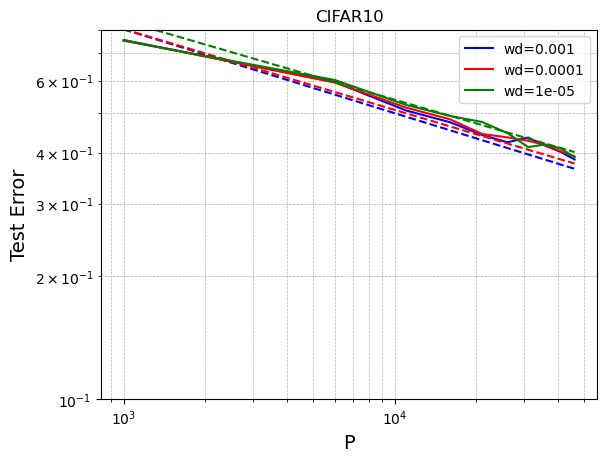

In [17]:
colors = np.array(["blue","red","green"])
eps_lam_star_P_arr = np.zeros((len(wd_arr),len(P_arr)))
lambda_star_arr = np.zeros((len(wd_arr),len(P_arr)))
for i_wd, wd in enumerate(wd_arr):
    for i_P,P in enumerate(P_arr):
         idx = np.nanargmin(mean_val_error_arr[i_wd,i_P])
         #idx = ((log_x_grid-l_power_law[i_P])**2) 
         eps_lam_star_P_arr[i_wd, i_P] = mean_val_error_arr[i_wd,i_P,idx]
         lambda_star_arr[i_wd, i_P] = log_x_grid[idx]
        
    
    plt.plot(P_arr, eps_lam_star_P_arr[i_wd], color=colors[i_wd], label=f"wd={wd}")
    
    plt.plot(P_arr, 2.5*k1*(k2*P_arr**gamma_2_arr[i_wd])**-gamma_1_arr[i_wd], "--", color=colors[i_wd])
    #plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((1e-1,0.8))
plt.show()

## Cifar10

/tmp/ipykernel_8529/2899039907.py:37: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


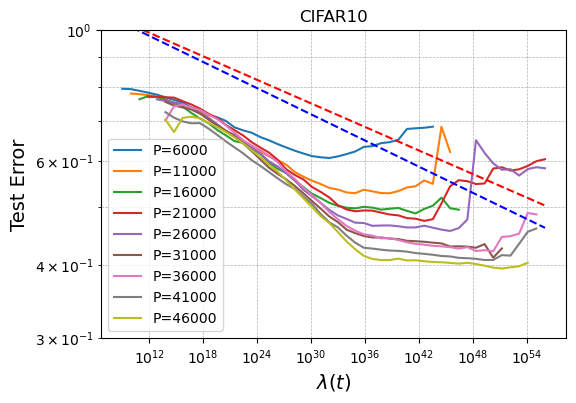

In [158]:
dataset = "CIFAR10"
P_arr = np.arange(6000, 46001, 5000)
seed_arr = np.arange(100,130)

wd=0.0
colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(9, 56, num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P,P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.005.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[P] = mean_val_error
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}")


gamma_1_a = (1/135)
k1_a = 1.2
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = (1/150)
k1_b = 1.19
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((0.3,1.))
plt.show()

In [159]:
C2 = 1e20

/tmp/ipykernel_8529/1776637260.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


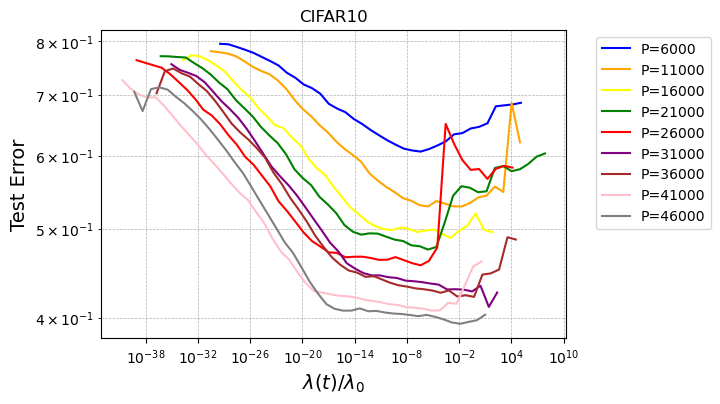

In [160]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.005.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_8529/3007734886.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


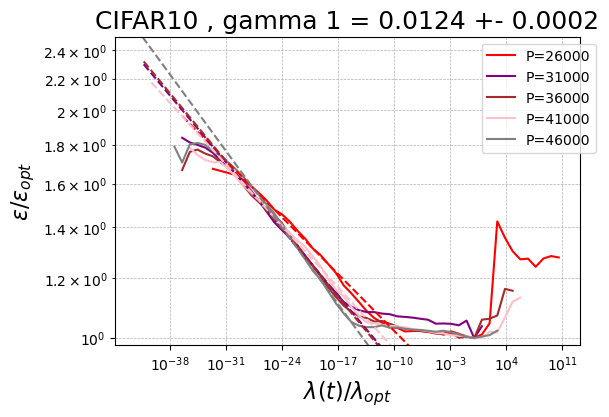

In [162]:
# Store interpolated results here
min_P = 4
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_INIT0.005.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = 1e-30
x_right = 1e-16
gamma_1, k1, err_gamma_1 = fit_phi_display(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right, colorlist)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_{opt}$", fontsize=16)
plt.ylabel(r"$\epsilon/\epsilon_{opt}$", fontsize=16)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.4f} +- {:.4f}".format(dataset, gamma_1, err_gamma_1), fontsize=18)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.98,2.5))
plt.show()

In [164]:
factor = 1

Fitted power law: k2 = 9.096e-33, gamma2 = 18.39


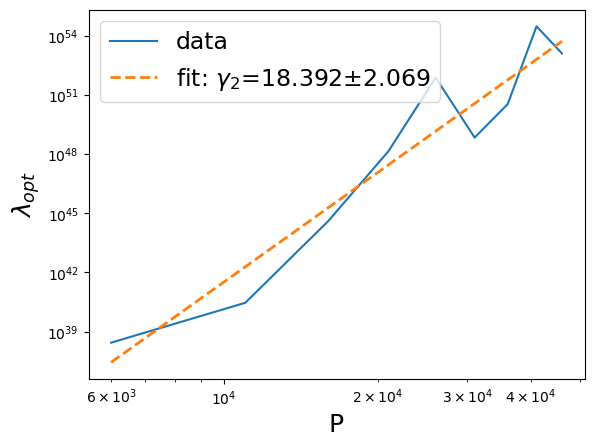

In [171]:
l_power_law = factor*l_0_arr[:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr, l_power_law)
plt.legend(fontsize=17)
plt.xlabel("P", fontsize=18)
plt.ylabel(r"$\lambda_{opt}$", fontsize=18)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

gamma pred 0.2288183247969192
[0.24291896 0.21145938 0.19408499 0.18237641 0.17367801 0.16682679
 0.16121526 0.15648841 0.15242185]


/tmp/ipykernel_82418/2409504850.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


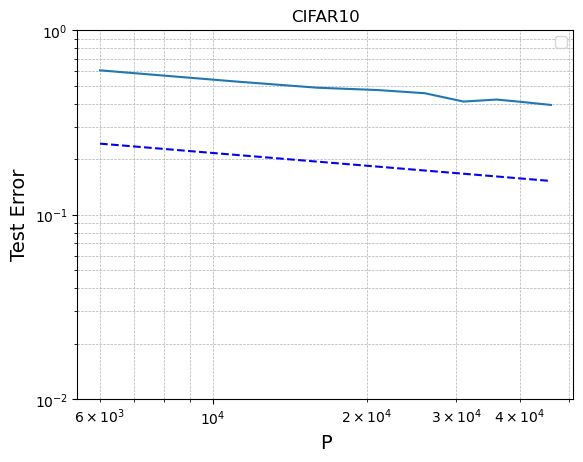

In [43]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

print("gamma pred", gamma_1*gamma_2)

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

print(k1*(k2*P_arr**gamma_2-C2)**-gamma_1)
plt.plot(P_arr, k1*(k2*P_arr**gamma_2-C2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.01))
plt.show()

In [45]:
name_save = "ViT_CIFAR10_rebuttal"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["C2"] = C2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)

## CIFAR100

/tmp/ipykernel_8529/2013085822.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


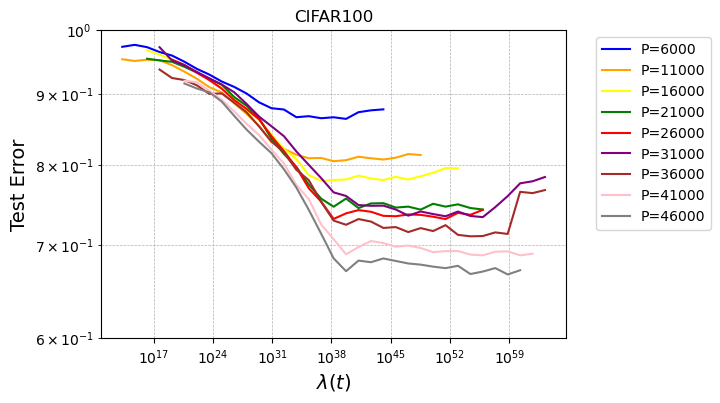

/tmp/ipykernel_8529/2013085822.py:81: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


<Figure size 600x400 with 0 Axes>

In [100]:
model = "ViT"
dataset = "CIFAR100"
final = "_INIT0.005"
WD = 0.0
P_arr = np.arange(6000, 46001, 5000)
seed_arr = np.arange(100,105)
log_x_grid = np.logspace(3, 75, num=50)
exponential=True

mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))
    
l_0_arr, to_save = plot_results(dataset, P_arr, seed_arr, log_x_grid, exponential=exponential, ylimit=(0.6,1.0))


/tmp/ipykernel_54519/490518209.py:30: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


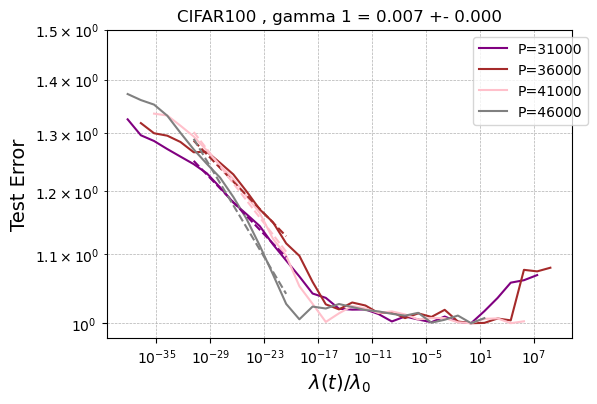

In [103]:
####################

min_P = 5
x_left = 1e-32
x_right = 1.5e-20

to_save["min_P"] = min_P

P_arr_fit, gamma_1, k1, err_gamma_1 = fit_gamma_1(min_P, exponential, x_left, x_right, ylimits = (0.98, 1.5))


Fitted power law: k2 = 3.967e-43, gamma2 = 21


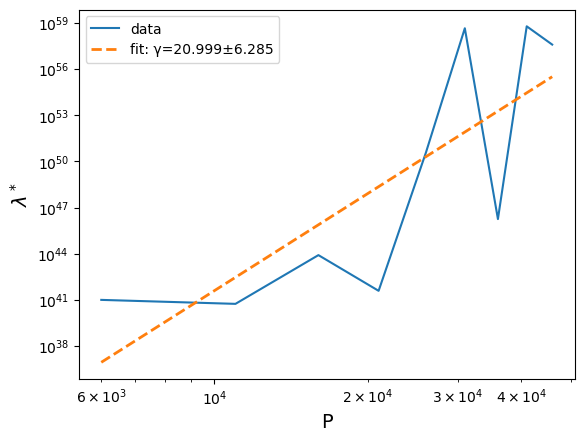

In [104]:
#####################

l_power_law = l_0_arr[:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr, l_power_law)
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

gamma_pred =  0.1429559624888969


/tmp/ipykernel_54519/1706596836.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


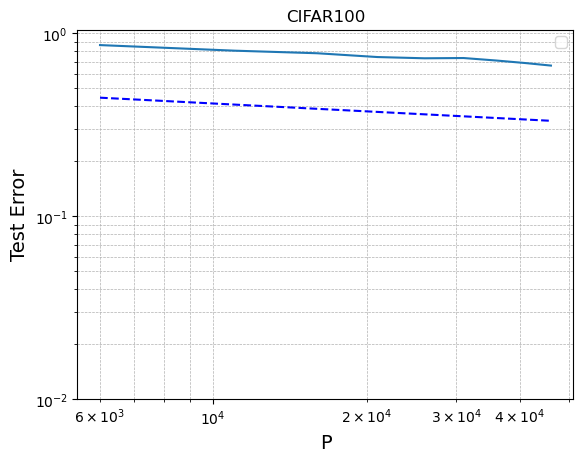

In [105]:
#####################

constant = 1
final_plot(P_arr, gamma_1, gamma_2, constant, ylimits = (1e-2,1.05))

In [106]:
#####################
name_save = "ViT_C100"
np.save(name_save, to_save)
print("saved to: "+ name_save+ ".npy")

saved to: ViT_C100.npy
